In [63]:
import pandas as pd
import sys
import os
import argparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import math
from pypinyin import pinyin, Style

import random
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score

os.environ['PYTHONHASHSEED'] = str(42)
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

## Study the index future contact trading and it's relationship to CSI 300 index:
    - IF is the index future contract linked to CSI 300 index
    - The main goal is to find out if index future contact trading info today can have any prediction power for tomorrow CSI index change.

#### Common functions

In [39]:
def read_idx_future(product='IF'):
    idx_future_map={
        'IF':'000300.SS', #CSI 300
        'IH':'510050.SS',  #CSI 50
        'IC':'510500.SS',  #ZZ 500
        'IM':'512100.SS'   #ZZ 1000

    }
    #df_future =pd.read_csv(f'data/future_{product}.csv', encoding="gb18030", index_col='datetime',parse_dates=True, date_parser=custom_date_parser)
    df_future =pd.read_csv(f'data/future_{product}.csv', encoding="gb18030", index_col='datetime',parse_dates=True, date_format='%Y%m%d')
    
    df_future=df_future.rename(columns={'Unnamed: 0':'dealer'})
    df_future['dealer']= df_future['dealer'].apply(lambda x:  ''.join(word[0] for word in pinyin(x, style=Style.NORMAL)) )

    #df_future['dealer']=df_future['dealer']
    if product=='IF':
        df_future=df_future[df_future.index >= '2021-03-11']
    #df_future['datetime']=pd.to_datetime(df_future['datetime'], format='%Y%m%d')
    start_date=min(df_future.index)
    last_date=max(df_future.index)

    idx_file=f'data/idx_{product}.csv'
    if os.path.exists(idx_file):
        df_idx = pd.read_csv(idx_file,  index_col=0,parse_dates=True, date_format='%Y-%m-%d')
        if df_idx.index[0]<=start_date and df_idx.index[-1]>=last_date:
            print(f'idx_{product} already exists, skip downloading')
            df_idx['next_day_ret']= df_idx['Close'].pct_change().shift(-1)*100
            return df_future, df_idx[(df_idx.index>=start_date) & (df_idx.index<=last_date)], start_date, last_date
    df_idx =yf.download(idx_future_map[product], start=start_date)
    df_idx = df_idx.droplevel('Ticker',axis=1)
    df_idx.to_csv(idx_file)
    df_idx['next_day_ret']= df_idx['Close'].pct_change().shift(-1)*100
    return df_future, df_idx[(df_idx.index>=start_date) & (df_idx.index<=last_date)], start_date,last_date   

def get_idx_future_top_traders(df_future, n):
    df_trader_vol= pd.DataFrame(df_future.groupby('dealer')['volume'].sum())
    df_trader_vol = df_trader_vol.sort_values(by='volume', ascending=False)
    return df_future[ df_future['dealer'].isin(df_trader_vol.index[:n])]

    df_trader_vol['volume'][n]


def get_total_trade_vol_top_dealers(df_future):
    df_trader_vol= pd.DataFrame(df_future.groupby('dealer')['volume'].sum())
    df_trader_vol = df_trader_vol.sort_values(by='volume', ascending=False)
    df =pd.DataFrame(columns=['n_top_dealers', 'percent_trade_volume'])
    total_trade_vol=df_future['volume'].sum()
    for n in range(0, len(df_future['dealer'].unique()),5):
        df.loc[len(df)] ={"n_top_dealers":n,"percent_trade_volume":df_trader_vol['volume'][:n].sum()/total_trade_vol}
    
    return df

def plot_one(df, char_type,x_col, y_col, title, color='skyblue'):
    plt.figure(figsize=(20, 5))
    if char_type=='barplot':
        sns.barplot(x=x_col, y=y_col, data=df, color=color)
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

def plot_n(df, n, x_col, y_cols, titles,colors):
    fig, axes = plt.subplots(n, 1, sharex=True, figsize=(20, 12))
    #for ax in list(axes):
    for i in range(n):
        sns.barplot(data=df, x=x_col, y=y_cols[i],ax=axes[i], color=colors[i])
        axes[i].set_title(titles[i])
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

def cal_IC(df_idx, df_future):
    future_cols=df_future.columns.drop(['dealer'])
    future_cols_without_dealer=df_future.columns.drop(['dealer'])
    df_future_top_by_date=df_future[future_cols_without_dealer].groupby(df_future.index).sum()
    ics = df_future_top_by_date[future_cols][:-1].corrwith(df_idx['next_day_ret'][:-1], method='pearson')
    df_ic=pd.DataFrame(ics)
    df_ic.reset_index(inplace=True)
    df_ic.columns=['Column','IC']
    return df_ic

def cal_corr(df_idx,df_future_top):
    df_corr= pd.DataFrame(columns=['dealer','column', 'Correlation', 'Sum'])
    top_dealers=df_future_top['dealer'].unique()
    future_cols=df_future_top.columns.drop(['dealer'])
    for dealer in top_dealers:
        future_cols=list(df_future_top.columns.drop(['dealer']).values)
        df_future_dealer=df_future_top[df_future_top['dealer']==dealer]
        df_idx_future_dealer =df_idx.merge(df_future_dealer, left_index=True, right_index=True, how='left')
        df_idx_future_dealer=df_idx_future_dealer[future_cols +['next_day_ret']]

        df_idx_future_dealer=df_idx_future_dealer[:-1].fillna(0)
        df_corr_dealer=df_idx_future_dealer[future_cols].corrwith(df_idx_future_dealer['next_day_ret'])
                
        for x in df_corr_dealer.index:
            df_corr.loc[len(df_corr)] ={"dealer":dealer,'column':x, 'Correlation':df_corr_dealer[x], 'Sum':df_future_dealer[x].sum()}
        
    return df_corr

def plot_index(df_idx, df_future_by_date):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 12), sharex=True)

# Step 3: Plot df on the first subplot
    sns.lineplot(data=df_idx[['next_day_ret']], ax=ax1)
    ax1.set_title('CSI 300 index change percent next day')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Values')
    ax1.tick_params(axis='x', rotation=45)

    # Step 4: Plot df3 on the second subplot

    sns.lineplot(data=df_idx, ax=ax2)
    ax2.set_title('CSI 300 Index Future Contract Trading Top Volumes Info')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Values')
    ax2.tick_params(axis='x', rotation=45)
    sns.lineplot(data=df_future_by_date, ax=ax2)
    ax2.legend(labels=df_future_by_date.columns, title='Columns', loc='upper left')
    ax2.tick_params(axis='x', rotation=45)

    # Step 5: Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

def pivote_df_future(df_future_top):
    df_future_pivots=[]
    #for col in df_future_top.columns.drop(['dealer','datetime']):
    for col in df_future_top.columns.drop(['dealer']):
        df_future_pivot=df_future_top.pivot(columns='dealer', values=col)
        df_future_pivot=df_future_pivot.fillna(0)
        df_future_pivot.columns= [x +f'_{col}' for x in df_future_pivot.columns]
        df_future_pivots.append(df_future_pivot)

    df_future_pivoted = pd.concat(df_future_pivots, axis=1)
    return df_future_pivoted
    

# Load data
    - future contract data into df_future
    - CSI index data from Yahoo into df_idx

In [40]:
df_future, df_idx, start_date,last_date=read_idx_future('IF')

print(df_idx.tail(2))
print(df_future.tail(2))

idx_IF already exists, skip downloading
                  Close         High          Low         Open  Volume  \
Date                                                                     
2025-07-02  3943.689941  3952.139893  3929.699951  3943.320068  147100   
2025-07-03  3968.070068  3971.620117  3945.139893  3949.399902  141000   

            next_day_ret  
Date                      
2025-07-02      0.618206  
2025-07-03      0.356176  
                  dealer  volume  volchange  buyvol  buyvolchange  sellvol  \
datetime                                                                     
2025-07-03  jinyuanqihuo     0.0        0.0   676.0         -16.0      0.0   
2025-07-03    yinheqihuo  3235.0      232.0  5902.0        -126.0   4461.0   

            sellvolchange  net_vol_diff  
datetime                                 
2025-07-03            0.0           -16  
2025-07-03          -57.0           -69  


In [41]:
df_idx[['next_day_ret']].tail()

,next_day_ret
Date,
2025-06-27,0.365144
2025-06-30,0.169710
2025-07-01,0.023586
2025-07-02,0.618206
2025-07-03,0.356176


#### Data preview

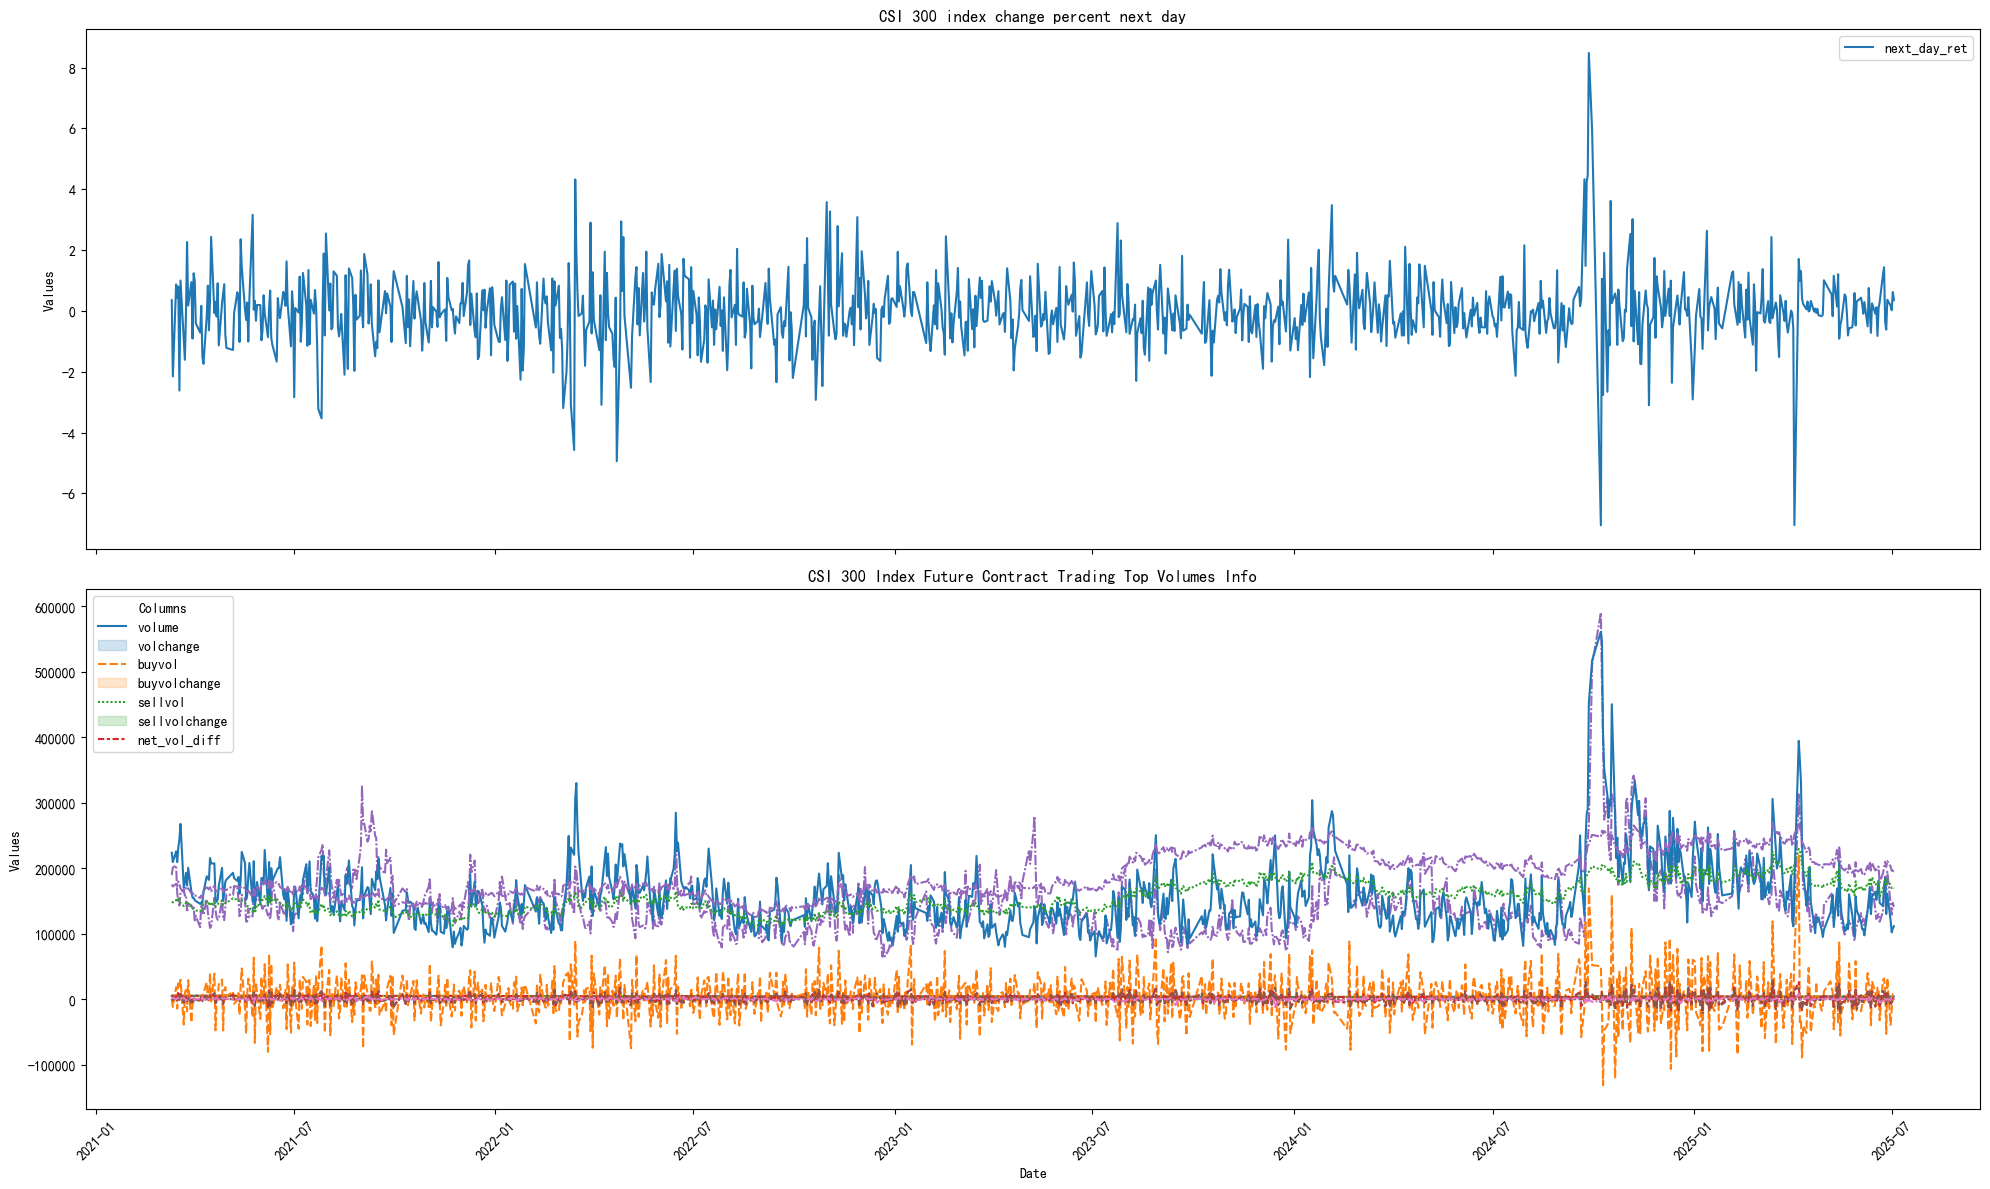

In [42]:
future_cols=df_future.columns.drop(['dealer'])
future_cols_without_dealer=df_future.columns.drop(['dealer'])
df_future_by_date=df_future[future_cols_without_dealer].groupby(df_future.index).sum()
plot_index(df_idx, df_future_by_date)


### Correlation and IC analysis between future contract trading data and CSI index change next day

#### The following analysis shows that
- Top 50 dealers contribute to 97.24% of total trading volume
- Top 100 dealers contribute to 99.73% of total trading volume

- Top 50 dealers will be more analysis in this notebook.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36920 entries, 2021-03-11 to 2025-07-03
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dealer         36920 non-null  object 
 1   volume         36920 non-null  float64
 2   volchange      36920 non-null  float64
 3   buyvol         36920 non-null  float64
 4   buyvolchange   36920 non-null  float64
 5   sellvol        36920 non-null  float64
 6   sellvolchange  36920 non-null  float64
 7   net_vol_diff   36920 non-null  int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 2.5+ MB
None


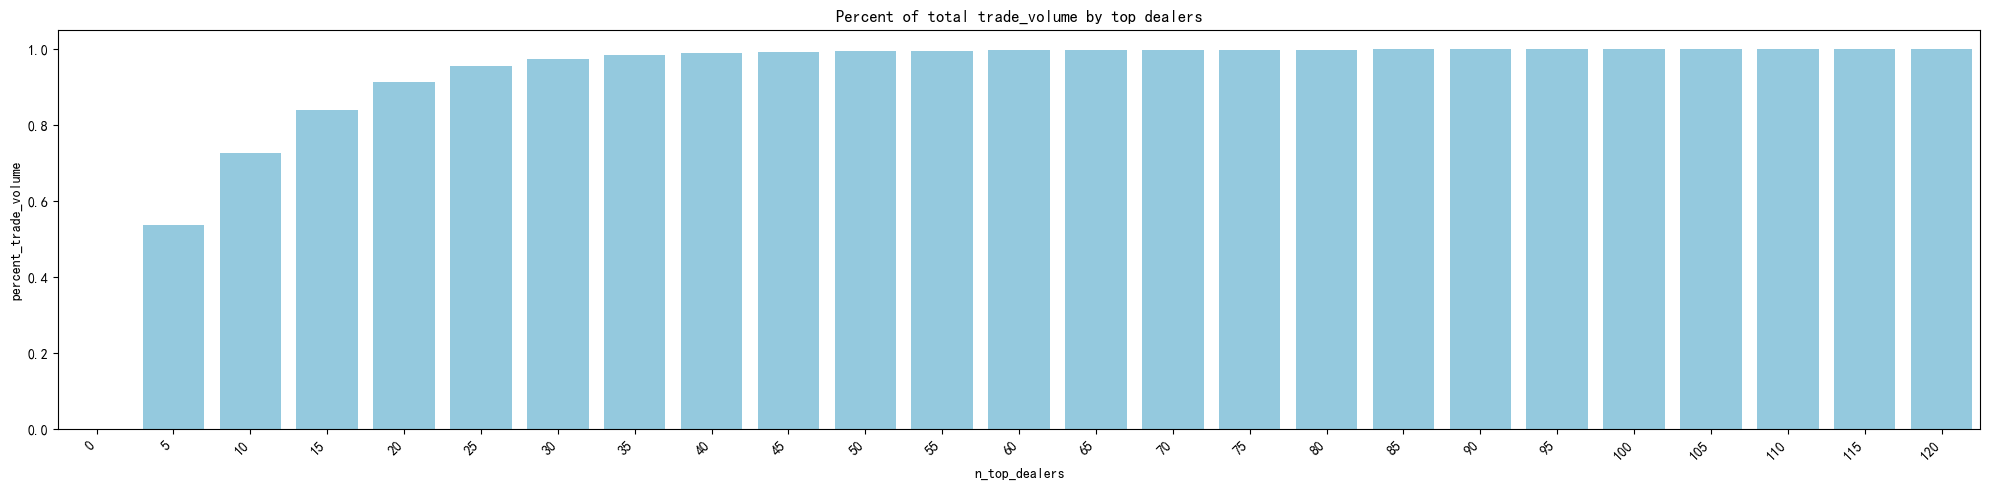

In [43]:
df_vol_percent=get_total_trade_vol_top_dealers(df_future) 
plot_one(df_vol_percent,'barplot',x_col='n_top_dealers', y_col='percent_trade_volume', title='Percent of total trade_volume by top dealers', color='skyblue')
df_future_top=get_idx_future_top_traders(df_future,50)
top_dealers=df_future_top['dealer'].unique()
print(df_future_top.info())



#### Find out the Information Coefficient (IC) between different future data columns of all dealers and CSI index change next data.
    - IF future contract volume seem to have highest IC with CSI index change next day
    - The future contract trading volume change has highest IC with CSI index change next day. Future contact buy volume and sell volume have high IC as well.
    - Surprisingly, the net trade volume has very small IC with the  CSI index change next day

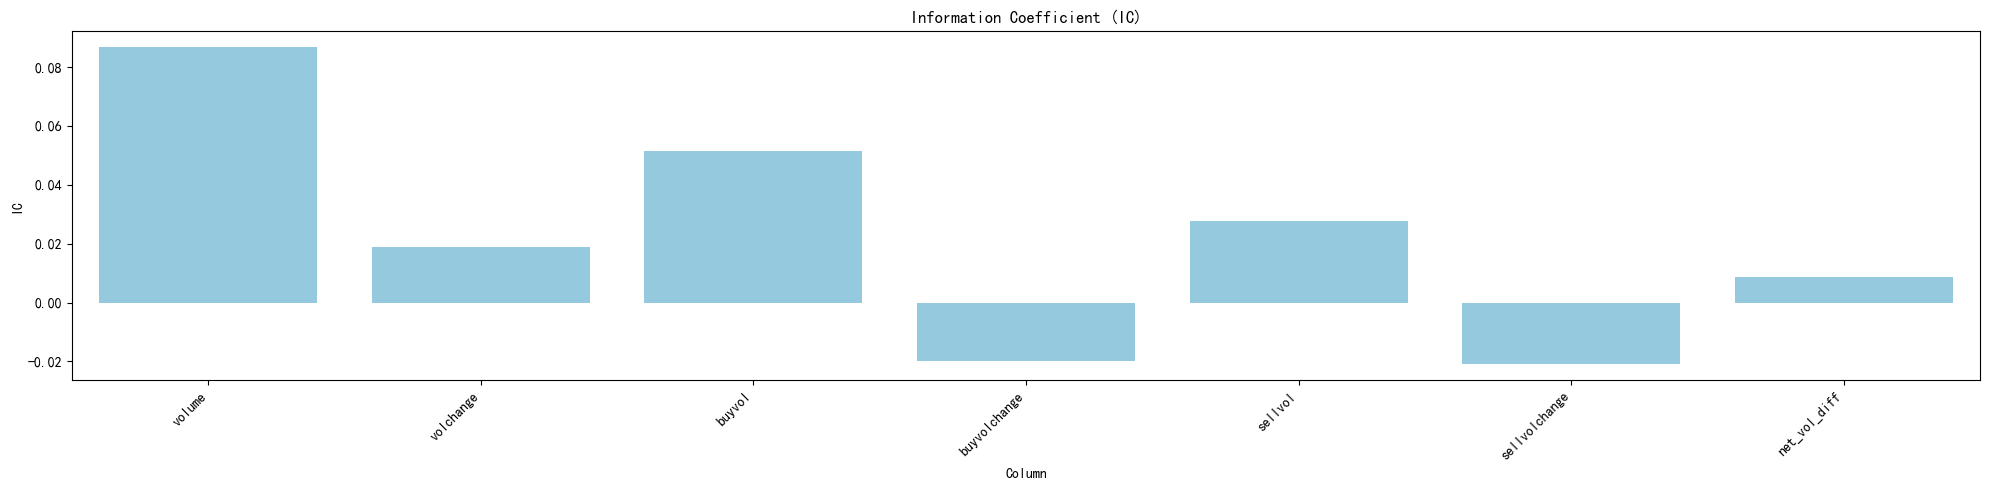

In [44]:
df_ic = cal_IC(df_idx, df_future_top)
plot_one(df_ic,'barplot',x_col='Column', y_col='IC', title='Information Coefficient (IC)', color='skyblue')

### check out if the net-future-vol is correlated to the next day's sp_idx

/home/ming/miniconda3/envs/qlib/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ming/miniconda3/envs/qlib/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


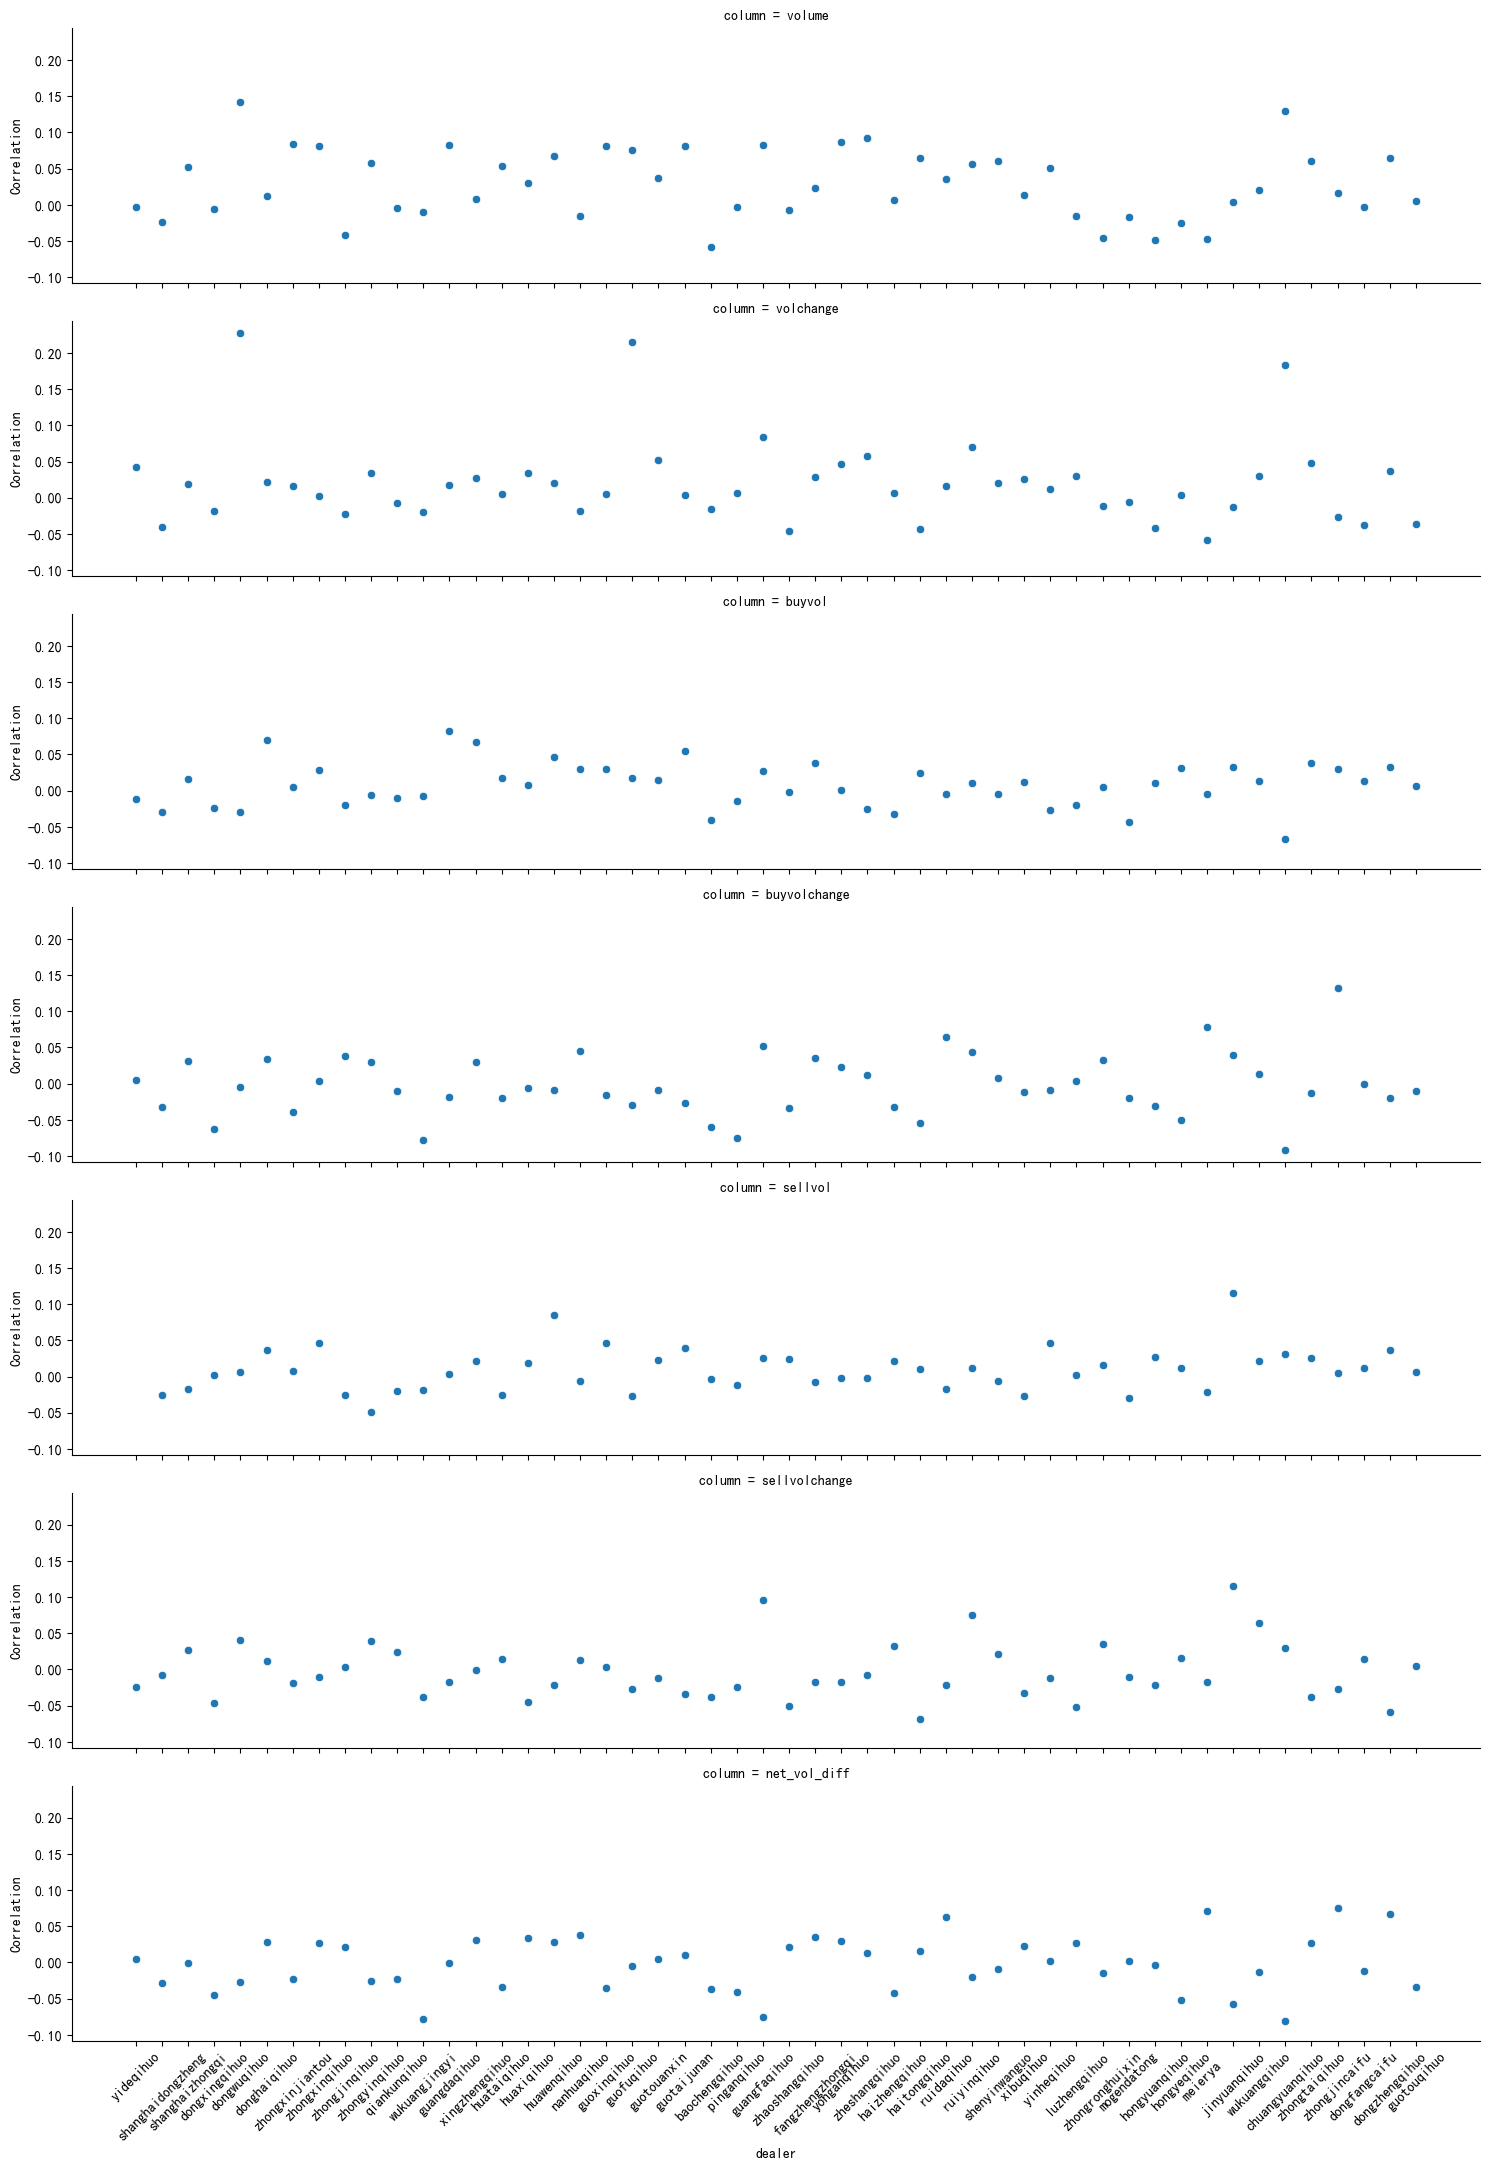

In [45]:

df_corr=cal_corr(df_idx, df_future_top)
g=sns.relplot(
    data=df_corr, 
    x="dealer", y="Correlation", row='column', facet_kws={'sharex': True}, height=3,aspect=5,

)
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45, labelright=True)

### Zoom in to see the correlation between future contract volume and CSI index change next day
    - those will highest future contract volume don't have the highest correlation 

/tmp/ipykernel_2684945/3484752466.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr_by_vol['Abs_Correlation'] =abs(df_corr_by_vol['Correlation'])


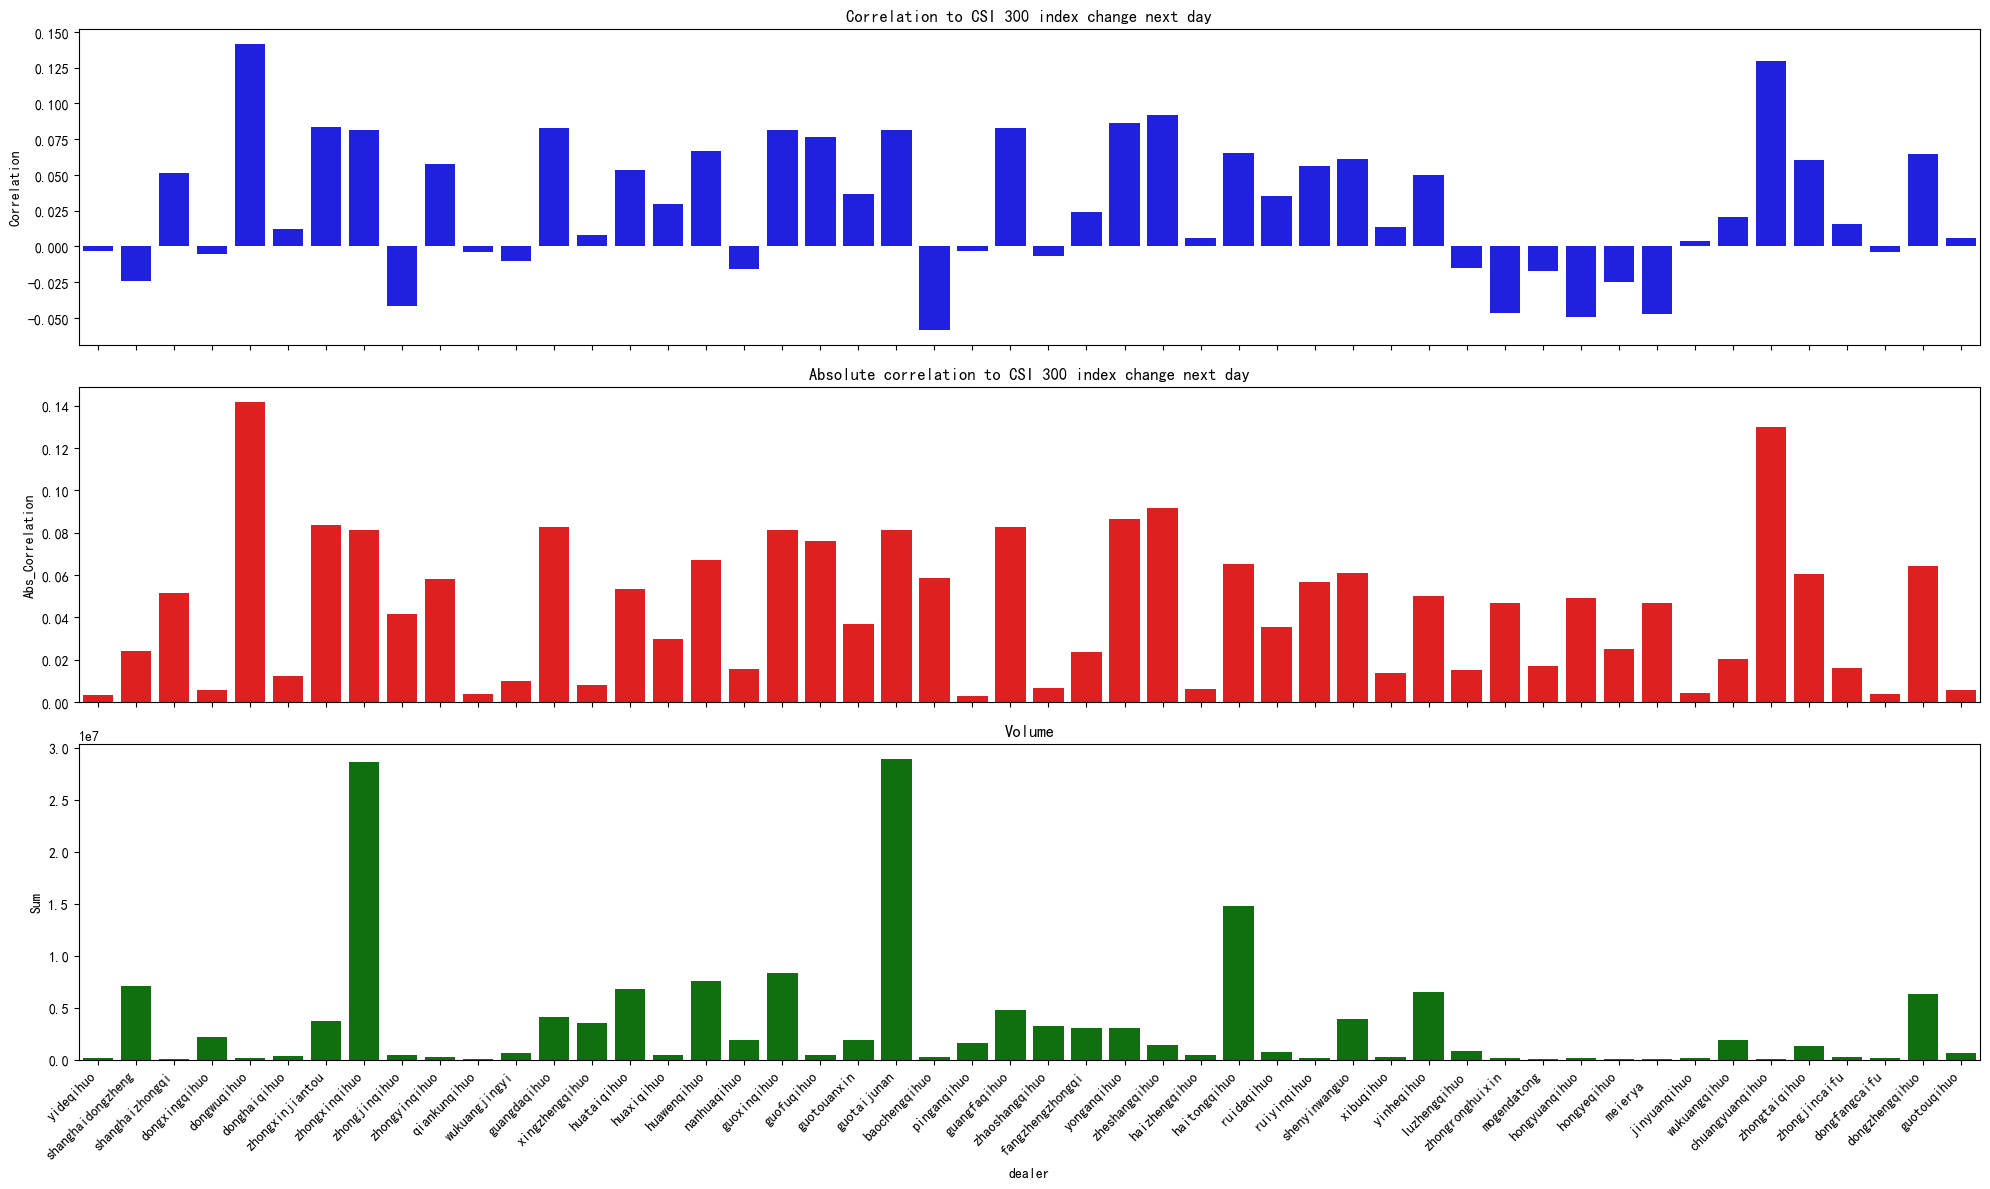

In [46]:

df_corr_by_vol= df_corr[df_corr['column']=='volume']
df_corr_by_vol['Abs_Correlation'] =abs(df_corr_by_vol['Correlation'])

plot_n(df_corr_by_vol,n=3, x_col='dealer', y_cols=['Correlation','Abs_Correlation','Sum'],titles=['Correlation to CSI 300 index change next day','Absolute correlation to CSI 300 index change next day','Volume'], colors=['blue','red','green'])


### Prepare data for model training
    - future contract trading data for all top 50 dealers will be pivoted into one row per trading day.
    

In [47]:

df_future_pivoted =pivote_df_future(df_future_top)
df_idx_with_future_trades =df_idx.merge(df_future_pivoted, left_index=True, right_index=True, how='left').fillna(0)
df_idx_with_future_trades.dropna(inplace=True)
print(df_idx_with_future_trades.tail(1))


                  Close         High          Low         Open  Volume  \
Date                                                                     
2025-07-03  3968.070068  3971.620117  3945.139893  3949.399902  141000   

            next_day_ret  baochengqihuo_volume  chuangyuanqihuo_volume  \
Date                                                                     
2025-07-03      0.356176                  92.0                     0.0   

            dongfangcaifu_volume  donghaiqihuo_volume  ...  \
Date                                                   ...   
2025-07-03                   0.0                123.0  ...   

            yonganqihuo_net_vol_diff  zhaoshangqihuo_net_vol_diff  \
Date                                                                
2025-07-03                     219.0                         83.0   

            zheshangqihuo_net_vol_diff  zhongjincaifu_net_vol_diff  \
Date                                                                 
2025-07-03         

### Do ML/AI

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.compose import TransformedTargetRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor

In [29]:

X= df_idx_with_future_trades.drop(columns=['next_day_ret','Close','High','Low','Open','Volume'])
y=df_idx_with_future_trades['next_day_ret']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
print(X_train.head(1))

            baochengqihuo_volume  chuangyuanqihuo_volume  \
Date                                                       
2022-03-30                   0.0                     0.0   

            dongfangcaifu_volume  donghaiqihuo_volume  dongwuqihuo_volume  \
Date                                                                        
2022-03-30                   0.0                  0.0                 0.0   

            dongxingqihuo_volume  dongzhengqihuo_volume  \
Date                                                      
2022-03-30                7319.0                    0.0   

            fangzhengzhongqi_volume  guangdaqihuo_volume  guangfaqihuo_volume  \
Date                                                                            
2022-03-30                   5306.0               6735.0               2888.0   

            ...  yonganqihuo_net_vol_diff  zhaoshangqihuo_net_vol_diff  \
Date        ...                                                          
2022-03-30  ...  

In [51]:
print(y_train[:1])

Date
2022-03-30   -0.740462
Name: next_day_ret, dtype: float64


In [52]:
models = {
    'LinearRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LinearRegression())]),

    'RidgeRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(random_state=42))]),
    'KnnRegressor': Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsRegressor())]),
    'DecisionTreeRegressor': Pipeline([
        ('scaler', StandardScaler()),
        ('dt', DecisionTreeRegressor(random_state=42))]),
    'SupportVectorRegressor': Pipeline([
        ('scaler', StandardScaler()),
        ('svr', SVR())]),
    'TransformedTargetRegressor': TransformedTargetRegressor(
        regressor=LinearRegression(),
        transformer=StandardScaler()
    ),
    
}

In [53]:
df_score = pd.DataFrame(columns=['Model', 'MSE'])
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name}: {mse:.8f}")
    df_score.loc[len(df_score)] = {'Model': name, 'MSE': mse}

LinearRegression: 2.31454833
RidgeRegression: 2.26711836
KnnRegressor: 1.46342424
DecisionTreeRegressor: 2.69321447
SupportVectorRegressor: 1.19181748
TransformedTargetRegressor: 2.31454833


In [54]:
voter = VotingRegressor(
    estimators=[(name, model) for name, model in models.items()]
)
voter.fit(X_train, y_train)
y_pred = voter.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

df_score.loc[len(df_score)] = {'Model': 'VotingRegressor', 'MSE': mse}


In [55]:
print(df_score)

                        Model       MSE
0            LinearRegression  2.314548
1             RidgeRegression  2.267118
2                KnnRegressor  1.463424
3       DecisionTreeRegressor  2.693214
4      SupportVectorRegressor  1.191817
5  TransformedTargetRegressor  2.314548
6             VotingRegressor  1.550903


#### IC from prediction of X_test is -0.026 which is much higher than any of IC calculated from any future contract data directly

In [56]:
df_IC_predicted =pd.DataFrame(columns=["product","predicted_IC"])

def cal_IC_from_prediction(model,X_test, y_test, product, df_IC_predicted):
    y_pred = model.predict(X_test)
    df_test_predict=pd.DataFrame({'test':y_test, 'predict':y_pred})

    ic_from_model_predict = df_test_predict['test'].corr(df_test_predict['predict'],method='pearson')
    print()
    df_IC_predicted.loc[len(df_IC_predicted)] = {"product":product,"predicted_IC":ic_from_model_predict}
    return df_IC_predicted

df_IC_predicted= cal_IC_from_prediction(voter,X_test, y_test,'IF', df_IC_predicted)
print(df_IC_predicted)


  product  predicted_IC
0      IF     -0.026285


InvalidParameterError: The 'cv' parameter of GridSearchCV must be an int in the range [2, inf), an object implementing 'split' and 'get_n_splits', an iterable or None. Got 1 instead.

In [ ]:
y_pred=grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
df_score.loc[len(df_score)] = {'Model': 'GridSearchCV', 'MSE': mse}

NameError: name 'grid_search' is not defined

In [31]:
print(df_score)

                        Model       MSE
0            LinearRegression  0.000267
1             RidgeRegression  0.000265
2                KnnRegressor  0.000156
3       DecisionTreeRegressor  0.000251
4      SupportVectorRegressor  0.000179
5  TransformedTargetRegressor  0.000267
6             VotingRegressor  0.000185
7                GridSearchCV  0.000187


### Prediction from voter model for change percent next day

In [57]:
y_pred = voter.predict(X_test)
df_test_predict=pd.DataFrame({'test':y_test, 'predict':y_pred})

ic_from_grid_search_predict = df_test_predict['test'].corr(df_test_predict['predict'],method='pearson')

print(ic_from_grid_search_predict)

-0.026284562991293666


In [54]:
y_pred = voter.predict(X_test)
df_test_predict=pd.DataFrame({'test':y_test, 'predict':y_pred})

ic_from_grid_search_predict = df_test_predict['test'].corr(df_test_predict['predict'],method='pearson')

print(ic_from_grid_search_predict)

0.15972924987151196


### Test out for CSI index products using following models
    VotingRegressor using the following models:
        - LinearRegression
        - KnnRegressor
        - DecisionTreeRegressor
        - SupportVectorRegressor
        - TransformedTargetRegressor
    AdoBoost
    XgbBoost
    TensorFlow 


In [ ]:
def cal_IC_from_prediction(model,X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    #test_loss, test_mae = model.evaluate(X_test, y_pred, verbose=0)
    df_test_predict=pd.DataFrame({'test':y_test, 'predict':y_pred})

    ic_from_model_predict = df_test_predict['test'].corr(df_test_predict['predict'],method='pearson')
    return ic_from_model_predict, mse 

def do_prediction(model, X_pred): 
    if isinstance(model, xgb.Booster):
        X_pred = xgb.DMatrix(X_pred, label=X_pred)

    y_pred = model.predict(X_pred)
    return y_pred
def do_prediction_tf(model, X_pred, y_normalizer): 
    y_pred = model.predict(X_pred)
    y_pred_scaled = model.predict(X_pred, verbose=0).flatten()
    y_pred = y_normalizer(y_pred_scaled)
    return y_pred[0]

def load_and_preprocess_data(product):
    np.random.seed(42)
    df_future, df_idx,start_date, last_date= read_idx_future(product)

    df_future_top=get_idx_future_top_traders(df_future,50)
    df_future_pivoted =pivote_df_future(df_future_top)
    df_idx_with_future_trades =df_idx.merge(df_future_pivoted, left_index=True, right_index=True, how='left').fillna(0)
    df_idx_with_future_trades.dropna(inplace=True)
    X= df_idx_with_future_trades.drop(columns=['next_day_ret','Close','High','Low','Open','Volume'])
    y=df_idx_with_future_trades['next_day_ret']
    return X,y, start_date, last_date  

def train_and_IC_voting(X_train, X_test, y_train, y_test, X_pred=None):
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    voter = VotingRegressor(
        estimators=[(name, model) for name, model in models.items()]
    )
    voter.fit(X_train, y_train)
    ic_from_model_predict,mse= cal_IC_from_prediction(voter,X_test, y_test)
    y_pred = voter.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    if X_pred is not None:
        y_pred =do_prediction(voter, X_pred)
    else:
        y_pred=None

    return 'VotingRegressor', model, ic_from_model_predict, mse, y_pred

def train_and_IC_adoBoost(X_train, X_test, y_train, y_test,X_pred=None):
    regr = AdaBoostRegressor(random_state=42, n_estimators=100)
    regr.fit(X_train, y_train)
    y_pred= regr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    df_test_predict=pd.DataFrame({'test':y_test, 'predict':y_pred})
    ic_from_model_predict = df_test_predict['test'].corr(df_test_predict['predict'],method='pearson')
    if X_pred is not None:
        y_pred =do_prediction(regr, X_pred)
    else:
        y_pred=None
    return 'AdaBoostRegressor', regr, ic_from_model_predict,mse, y_pred

def train_and_IC_XgbBoost(X_train, X_test, y_train, y_test,X_pred=None):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Set parameters for regression
    params = {
        'objective': 'reg:squarederror',  # For regression
        'max_depth': 3,
        'learning_rate': 0.1,
        #'n_estimators': 100,
        'eval_metric': 'rmse'  # Root Mean Squared Error
    }
    xgb_model = xgb.train(params, dtrain, num_boost_round=100)
    y_pred= xgb_model.predict(dtest)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    df_test_predict=pd.DataFrame({'test':y_test, 'predict':y_pred})
    ic_from_model_predict = df_test_predict['test'].corr(df_test_predict['predict'],method='pearson')
    if X_pred is not None:
        y_pred =do_prediction(xgb_model, X_pred)
    else:
        y_pred=None
    return 'XgbBoost', xgb_model, ic_from_model_predict,mse, y_pred


from scipy.stats import pearsonr
class EarlyStoppingByValLoss(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(EarlyStoppingByValLoss, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.threshold:
            print(f'\nStopping search: val_loss ({val_loss:.4f}) is below threshold ({self.threshold:.4f})')
            self.model.stop_training = True
'''
    StandardScaler is applied to both features and target variable.
'''
def train_and_IC_TensorFlow(X_train, X_test, y_train, y_test, X_predict, df=None):
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.to_numpy()

    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.to_numpy()

    if isinstance(y_train, (pd.Series, pd.DataFrame)):
        y_train = y_train.squeeze().to_numpy()
    if isinstance(y_test, (pd.Series, pd.DataFrame)):
        y_test = y_test.squeeze().to_numpy()



    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # Fit ONLY on train, transform all
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
      # For future/prediction data

    y_train = y_train.reshape(-1,1)
    y_test = y_test.reshape(-1,1)


    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    # 4. Build TensorFlow regression model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(96, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)  # Linear output for regression
    ])
    learning_rate=0.008
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),                  
                  loss='mse', metrics=['mae'])

    # 5. Train model
    history = model.fit(
        X_train_scaled, y_train_scaled,
        epochs=200, batch_size=32,
        validation_data=(X_test_scaled, y_test_scaled),
        verbose=0
    )

    # 6. Evaluate and predict
    test_loss, test_mae = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
    print(f"Test Loss (scaled): {test_loss}, Test MAE (scaled): {test_mae}")


   # Predict on X_test_scaled
    y_test_pred_scaled = model.predict(X_test_scaled)

    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
    print("Predicted:", y_test_pred.flatten()[-5:])
    print("Ground truth:", y_test.flatten()[-5:])


    mse= mean_squared_error(y_test, y_test_pred)
    print(f"Mean Squared Error (Test): {mse:.3f}")
    df_test_predict=pd.DataFrame({'test':y_test.flatten(), 'predict':y_test_pred.flatten()})
    ic_from_model_predict = df_test_predict['test'].corr(df_test_predict['predict'],method='pearson')

    # Predict on X_predict_scaled
    if X_predict is not None:
        if isinstance(X_predict, (pd.Series, pd.DataFrame)):
            X_predict = X_predict.squeeze().to_numpy()

        X_predict_scaled = scaler_X.transform(X_predict)
        y_pred_scaled = model.predict(X_predict_scaled)

        # Inverse transform predictions and targets to original scale
        y_pred = scaler_y.inverse_transform(y_pred_scaled)
    else:
        y_pred = None

    return 'Tensorflow', model, ic_from_model_predict, mse, y_pred.flatten()



def train_predict_all_models(product,df_IC_predicted):
    X,y,start_date,last_date = load_and_preprocess_data(product)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_pred = X[-5:]  # Use the last 5 rows for prediction
    for train_and_IC_func in [train_and_IC_TensorFlow, train_and_IC_XgbBoost, train_and_IC_voting, train_and_IC_adoBoost]:
        
        model_name, model, ic_from_model,mse,predicted = train_and_IC_func(X_train, X_test, y_train, y_test,X_pred)
        df_IC_predicted.loc[len(df_IC_predicted)] = {"product": product,"model":model_name,'IC%':ic_from_model*100,'rmse':math.sqrt(mse),'prediction%':predicted[-1]*100 if predicted is not None else None,'start_date':start_date,'last_date':last_date}

    return df_IC_predicted



### Run all models for all csi index future contract products, IH, IF, IC, IM

In [68]:
products = 'IF,IH,IC,IM'
df_IC_predicted =pd.DataFrame(columns=["product",'model','IC%','rmse','prediction%','start_date','last_date'])
for product in products.split(','):
    train_predict_all_models(product,df_IC_predicted)
pd.set_option('display.max_columns', None)
print(df_IC_predicted)

idx_IF already exists, skip downloading


/home/ming/miniconda3/envs/qlib/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-05 16:08:28.116419: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes wi

Test Loss (scaled): 1.1616708040237427, Test MAE (scaled): 0.833730936050415


2025-07-05 16:10:46.226026: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted: [ 0.15373772 -0.38546363  0.11156338  0.15373772 -0.24437094]
Ground truth: [-0.23772051  1.81051266 -0.33060714  1.15570326 -1.60853692]
Mean Squared Error (Test): 1.536
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
idx_IH already exists, skip downloading


/home/ming/miniconda3/envs/qlib/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-05 16:11:06.382014: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes wi

Test Loss (scaled): 1.5642127990722656, Test MAE (scaled): 0.9026683568954468
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

2025-07-05 16:13:28.303118: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted: [ 0.00720465 -1.187236   -0.39079857 -0.32540715  0.04820511]
Ground truth: [ 0.32773304  0.26912481 -2.90217637 -0.39640202  1.13722408]
Mean Squared Error (Test): 2.003
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
idx_IC already exists, skip downloading


/home/ming/miniconda3/envs/qlib/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-05 16:13:50.207398: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes wi

Test Loss (scaled): 1.023324728012085, Test MAE (scaled): 0.6758568286895752
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

2025-07-05 16:16:13.755434: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predicted: [ 0.33157808 -0.49910733  1.2734188  -0.13204834  1.1074746 ]
Ground truth: [-1.05206145 -0.95319451 -0.49148686 -0.45375258  2.55696354]
Mean Squared Error (Test): 1.828
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
idx_IM already exists, skip downloading


/home/ming/miniconda3/envs/qlib/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-05 16:16:38.400530: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes wi

Test Loss (scaled): 0.10208890587091446, Test MAE (scaled): 0.21039196848869324
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted: [ 1.2418481  0.5465343  0.3982497  0.6532632 -2.401512 ]
Ground truth: [ 8.92678106 -0.58421551  1.26771665  4.56375843 -0.26833694]
Mean Squared Error (Test): 5.968
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
   product              model        IC%       rmse  prediction% start_date  \
0       IF         Tensorflow   0.401426   1.239543    23.515532 2021-03-11   
1       IF           XgbBoost   5.392898   1.102974     7.768746 2021-03-11   
2       IF    VotingRegressor  -2.628456   1.245353    37.556987 2021-03-11   
3       IF  AdaBoostRegressor  -6.799853   1.137156    87.979512 2021-03-11   
4       IH         Tensorflow  -9.638394   1.415375    44.419930 2021-01-04   
5       IH           XgbBoost  -2.440734   1.235854     0.985789 2021-01-04   
6       IH    VotingRegressor  -4.786681   1.321331    24.157753 2021-01-04   
7       IH  AdaBoostRegressor  -0.5

### GridSearchCV for VotingRegressor

In [ ]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
param_grid = {
    'LinearRegression__lr__fit_intercept': [True, False],
    'RidgeRegression__ridge__alpha': [0.1, 1.0, 10.0],
    'RidgeRegression__ridge__fit_intercept': [True, False],
    'KnnRegressor__knn__n_neighbors': [3, 5, 7],
    'KnnRegressor__knn__weights': ['uniform', 'distance'],
    'DecisionTreeRegressor__dt__max_depth': [None, 5, 10],
    'DecisionTreeRegressor__dt__min_samples_split': [2, 5],
    'SupportVectorRegressor__svr__C': [0.1, 1.0, 10.0],
    'SupportVectorRegressor__svr__kernel': ['rbf', 'linear'],
    'SupportVectorRegressor__svr__epsilon': [0.1, 0.2],
    'TransformedTargetRegressor__regressor__fit_intercept': [True, False],
    #'TransformedTargetRegressor__transformer': [StandardScaler(), PowerTransformer(method='yeo-johnson'), None],

    #'weights': [[1, 1, 1, 1, 1], [2, 1, 1, 1, 1], [1, 2, 1, 1, 1], [1, 1, 2, 1, 1], [1, 1, 1, 2, 1], [1, 1, 1, 1, 2]]
}
grid_search = GridSearchCV(
        estimator=voter,
        param_grid=param_grid,
        cv=1,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
grid_search.fit(X_train, y_train)
results = {
    'best_score': grid_search.best_score_,
    'best_params': grid_search.best_params_,
    'best_estimator': grid_search.best_estimator_
}
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

### Keras Tuner for tensorflow

In [ ]:
import shutil
import keras_tuner as kt
def build_model(hp, X_train_np):
    # Build model
    model = tf.keras.Sequential()
    # Tune number of layers (2 to 4)    
    for i in range(hp.Int('num_layers', 2, 4)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
            activation='relu'
        ))
    
    model.add(tf.keras.layers.Dense(1))  # Output layer for regression

    # Tune learning rate
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    return model

def data_normalize(X_train, X_test, y_train, y_test, X_predict=None):
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.to_numpy()

    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.to_numpy()

    if isinstance(y_train, (pd.Series, pd.DataFrame)):
        y_train = y_train.squeeze().to_numpy()
    if isinstance(y_test, (pd.Series, pd.DataFrame)):
        y_test = y_test.squeeze().to_numpy()



    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # Fit ONLY on train, transform all
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
      # For future/prediction data

    y_train = y_train.reshape(-1,1)
    y_test = y_test.reshape(-1,1)


    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)
    if X_predict is not None:
        if isinstance(X_predict, (pd.Series, pd.DataFrame)):
            X_predict = X_predict.squeeze().to_numpy()

        X_predict_scaled = scaler_X.transform(X_predict)
        y_pred_scaled = model.predict(X_predict_scaled)

        # Inverse transform predictions and targets to original scale
        y_pred = scaler_y.inverse_transform(y_pred_scaled)
    else:
        y_pred = None

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_y

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_y
def train_and_IC_TensorFlow_search(X_train, X_test, y_train, y_test):
    tuner_dir = 'tuner_dir'
    if os.path.exists(tuner_dir):
        shutil.rmtree(tuner_dir)
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_y = data_normalize(X_train, X_test, y_train, y_test,X_predict=None)


    # Initialize Keras Tuner
    tuner = kt.Hyperband(
        lambda hp: build_model(hp, X_train_scaled),  # Pass X_train_np explicitly
        objective='val_loss',
        max_epochs=100,
        factor=3,
        directory='tuner_dir',
        project_name='regression_tuning'
    )

    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True
    )
    val_loss_threshold=1.8e-8
    early_stop_by_val_loss = EarlyStoppingByValLoss(threshold=val_loss_threshold)
    # Search for best hyperparameters
    tuner.search(
        X_train_scaled, y_train_scaled,
        epochs=100,
        validation_data=(X_test_scaled, y_test_scaled),
        callbacks=[early_stopping,early_stop_by_val_loss],
        verbose=1
    )

    # Get best model
    best_model = tuner.get_best_models(num_models=1)[0]
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("Best Hyperparameters:")
    print(best_hps.values)
    print(best_model.summary())
    # Train best model
    history = best_model.fit(
        X_train_scaled, y_train_scaled,
        epochs=100,
        batch_size=32,
        validation_data=(X_test_scaled, y_test_scaled),
        callbacks=[early_stopping],
        verbose=1
    )
    
    mse = mean_squared_error(y_test, y_pred[0])
    r2 = r2_score(y_test, y_pred[0])
    ic = pearsonr(y_test, y_pred[0])[0]
    print(f"TensorFlow Mean Squared Error (Test): {mse:.3f}")
    print(f"TensorFlow R² Score (Test): {r2:.3f}")
    print(f"TensorFlow Information Coefficient (Test): {ic:.3f}")
    print("TensorFlow Sample Actual vs Predicted (first 5):")
    print(pd.DataFrame({'Actual': y_test[-5:], 'Predicted': y_pred[0][-5:]}))

    return "TensorFlow", best_model, ic, mse,None


train_and_IC_TensorFlow_search(X_train, X_test, y_train, y_test)


SyntaxError: invalid syntax (1846579184.py, line 131)